In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sqlite3
import taxis
import weather
from utils import *
import constants
from visualize import *
from sklearn.linear_model import *
from sklearn.kernel_ridge import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from datetime import datetime
from sklearn.cluster import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from matplotlib import cm
from sklearn.metrics import mean_squared_error

DBNAME="../taxis.db"
#LAT=1.380766
#LON=103.891675
#LAT=1.303693
#LON=103.844952
LAT=1.299067
LON=103.845810

holidays=['20170626']
def peak(h,m,w):
    return 1 if ((w==1 and (h>=6 and (h <=9 and m<30)) or (h >= 18))) else 0

def weekday(d):
    dt=datetime.strptime(d,"%Y%m%d")
    return 1 if datetime.isoweekday(dt)<6 else 0


In [2]:
dates=taxis.get_dates(DBNAME)
dates=[str(x[0]) for x in dates]
dates


['20170624',
 '20170625',
 '20170626',
 '20170627',
 '20170628',
 '20170629',
 '20170630',
 '20170701',
 '20170702',
 '20170703',
 '20170704',
 '20170705',
 '20170706',
 '20170707',
 '20170708']

In [3]:
w=weather.getdf_date(DBNAME,'20170701')
w['Hour']=w.apply(lambda x:int(x['Time'][:2]),axis=1)
w=w.drop(['Point','Time','Location'],axis=1)
w.head()

,X,Y,Forecast,Hour
0,19,0,FN,0
1,7,2,FN,0
2,18,3,FN,0
3,2,4,FN,0
4,15,4,FN,0


In [4]:
def process_date(date):
    if weekday(date)==0:
        return None
    df=taxis.getdf_loc_date(DBNAME,date,LAT,LON)
    h=df.quantile(q=0.8)['TaxiCount']
    l=df.quantile(q=0.2)['TaxiCount']
    df['Date']=date
    df['Hour']=df.apply(lambda r:int(r['Time'][:2]),axis=1)
    df['Minute']=df.apply(lambda r:int(r['Time'][2:]),axis=1)
    df['Weekday']=df.apply(lambda r: weekday(r['Date']),axis=1)
    df['Holiday']=df.apply(lambda r: 1 if r['Date'] in holidays else 0,axis=1)
    df['PeakHour']=df.apply(lambda r: peak(r['Hour'],r['Minute'],r['Weekday']),axis=1)
    def get_weather(r):
        x=r['X']
        y=r['Y']
        h=r['Hour']
        f=w.query('X>=@x-1 and X<=@x+1 and Y>=@y-1 and Y<=@y+1 and Hour==@h')['Forecast'].tolist()[0] 
        return constants.WEATHER_CODES[f]
    df['Forecast']=df.apply(get_weather,axis=1)
    df=df.query('(TaxiCount>=@l and TaxiCount<=@h) and Weekday==1')[['Hour','Minute','PeakHour','TaxiCount','Forecast']]
    return df


In [5]:
data=[process_date(date) for date in dates]
data=[x for x in data if x is not None]

0.59938263389
0.348595575046
0.369226213422
0.332386117993
0.398124498401
0.187829021213
0.289749270403
0.343343537238
0.309027988316
             Hour      Minute    PeakHour   TaxiCount    Forecast
count  176.000000  176.000000  176.000000  176.000000  176.000000
mean    13.375000   27.443182    0.403409   52.420455    0.517045
std      7.031866   16.835241    0.491981   15.490252    0.090990
min      0.000000    0.000000    0.000000   30.000000    0.500000
25%      7.750000   15.000000    0.000000   38.000000    0.500000
50%     15.000000   30.000000    0.000000   51.500000    0.500000
75%     20.000000   40.000000    1.000000   66.000000    0.500000
max     23.000000   55.000000    1.000000   80.000000    1.000000
191.192272727


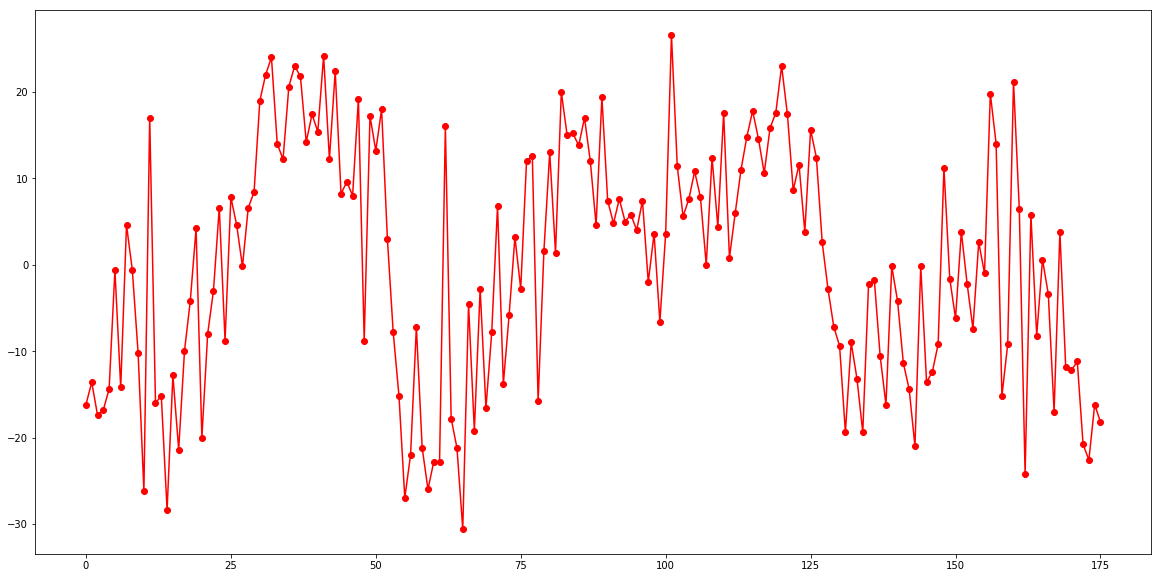

In [6]:
kn=KNeighborsRegressor()
for df in data[:-1]:
    X=df.drop(['TaxiCount','PeakHour','Forecast'],axis=1).as_matrix()
    y=np.array(df['TaxiCount'].tolist()).reshape(-1,1)
    kn.fit(X,y)
    print kn.score(X,y)
    
test=data[-1]

print test.describe()

Xt=test.drop(['TaxiCount','PeakHour','Forecast'],axis=1).as_matrix()
yt=np.array(test['TaxiCount'].tolist()).reshape(-1,1)
P=kn.predict(Xt)
e=[x-y for x,y in zip(P,yt)]

print mean_squared_error(yt,P)

#plt.plot(yt,'-g')
#plt.plot(P,'-b')
plt.plot(e,'-ro')
plt.show()

/Users/hari/python/py2/taxidata/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.961767766702
0.299219172192
0.161102612237
0.473823690615
0.173155172605
0.0877419285825
0.499800644464
0.569740693002
0.451192362053
             Hour      Minute    PeakHour   TaxiCount    Forecast
count  176.000000  176.000000  176.000000  176.000000  176.000000
mean    13.375000   27.443182    0.403409   52.420455    0.517045
std      7.031866   16.835241    0.491981   15.490252    0.090990
min      0.000000    0.000000    0.000000   30.000000    0.500000
25%      7.750000   15.000000    0.000000   38.000000    0.500000
50%     15.000000   30.000000    0.000000   51.500000    0.500000
75%     20.000000   40.000000    1.000000   66.000000    0.500000
max     23.000000   55.000000    1.000000   80.000000    1.000000
176
101.558077301


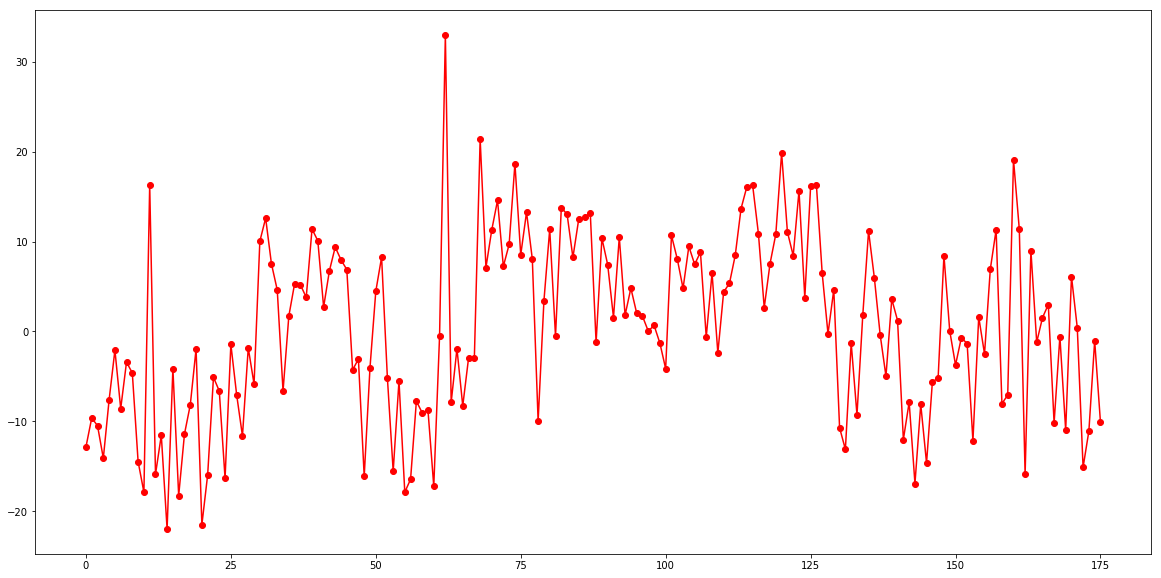

In [12]:
rf=RandomForestRegressor(warm_start=True)
for df in data[:-1]:
    X=df.drop(['TaxiCount','PeakHour','Forecast'],axis=1).as_matrix()
    y=np.array(df['TaxiCount'].tolist()).reshape(-1,1)
    rf.fit(X,y)
    rf.n_estimators+=10
    print rf.score(X,y)
    
test=data[-1]

print test.describe()

Xt=test.drop(['TaxiCount','PeakHour','Forecast'],axis=1).as_matrix()
yt=np.array(test['TaxiCount'].tolist()).reshape(-1,1)
P=rf.predict(Xt)
e=[x-y for x,y in zip(P,yt)]

print len(e)
print mean_squared_error(yt,P)

#plt.plot(yt,'-g')
#plt.plot(P,'-b')
plt.plot(e,'-ro')
plt.show()

In [15]:
h=20
grid=create_grid(h)
d=get_taxi_data()
points=d['features'][0]['geometry']['coordinates']
for lon,lat in points:
    x,y=get_grid_cell(lat,lon,h)
    grid[y][x]+=1

n=datetime.now()
h=n.hour
m=int(5 * round(float(n.minute)/5))
p=1 if datetime.isoweekday(n)<6 else 0
w=1
print h,m,p
x,y=get_grid_cell(LAT,LON)
X=np.array([h,m]).reshape(1,-1)
print rf.predict(X)
print kn.predict(X)
print grid[y][x]

22 55 1
[ 60.]
[[ 56.8]]
67


In [9]:
print rf.feature_importances_

[ 0.76694278  0.23305722]
